In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 2

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 2 in 2 days (history doubles the backlook)

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised train chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 1s 273us/step - loss: 0.1016 - val_loss: 0.0334
Epoch 2/24
4059/4059 [==============================] - 1s 157us/step - loss: 0.0136 - val_loss: 0.0092
Epoch 3/24
4059/4059 [==============================] - 1s 154us/step - loss: 0.0063 - val_loss: 7.8213e-04
Epoch 4/24
4059/4059 [==============================] - 1s 158us/step - loss: 0.0017 - val_loss: 6.6367e-04
Epoch 5/24
4059/4059 [==============================] - 1s 156us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/24
4059/4059 [==============================] - 1s 154us/step - loss: 8.6626e-04 - val_loss: 6.1638e-04
Epoch 7/24
4059/4059 [==============================] - 1s 156us/step - loss: 7.4782e-04 - val_loss: 7.3978e-04
Epoch 8/24
4059/4059 [==============================] - 1s 157us/s

4059/4059 [==============================] - 1s 328us/step - loss: 0.0014 - val_loss: 8.8694e-04
Epoch 22/24
4059/4059 [==============================] - 1s 326us/step - loss: 0.0014 - val_loss: 8.0041e-04
Epoch 23/24
4059/4059 [==============================] - 1s 325us/step - loss: 0.0013 - val_loss: 8.0405e-04
Epoch 24/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0013 - val_loss: 7.8000e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0579 - val_loss: 0.0256
Epoch 2/24
4059/4059 [==============================] - 2s 399us/step - loss: 0.0098 - val_loss: 0.0010
Epoch 3/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0047 - val_loss: 0.0019
Epoch 4/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0029 - val_loss: 0.0013
Epoch 5/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 6/2

Epoch 24/24
4059/4059 [==============================] - 2s 399us/step - loss: 0.0015 - val_loss: 8.5708e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 3s 771us/step - loss: 3.5470 - val_loss: 0.1235
Epoch 2/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0625 - val_loss: 0.2847
Epoch 3/24
4059/4059 [==============================] - 2s 533us/step - loss: 0.0490 - val_loss: 0.0040
Epoch 4/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0111 - val_loss: 0.0202
Epoch 5/24
4059/4059 [==============================] - 2s 524us/step - loss: 0.0329 - val_loss: 0.0050
Epoch 6/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0047 - val_loss: 0.0041
Epoch 7/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0040 - val_loss: 0.0169
Epoch 8/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0088 - val_loss: 0.0308
Epoch 9/24
4

4059/4059 [==============================] - 2s 405us/step - loss: 0.0697 - val_loss: 0.0202
Epoch 5/24
4059/4059 [==============================] - 2s 405us/step - loss: 0.0681 - val_loss: 0.0297
Epoch 6/24
4059/4059 [==============================] - 2s 406us/step - loss: 0.0662 - val_loss: 0.0374
Epoch 7/24
4059/4059 [==============================] - 2s 403us/step - loss: 0.0659 - val_loss: 0.0400
Epoch 8/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0659 - val_loss: 0.0396
Epoch 9/24
4059/4059 [==============================] - 2s 404us/step - loss: 0.0659 - val_loss: 0.0388
Epoch 10/24
4059/4059 [==============================] - 2s 406us/step - loss: 0.0659 - val_loss: 0.0389
Epoch 11/24
4059/4059 [==============================] - 2s 410us/step - loss: 0.0659 - val_loss: 0.0392
Epoch 12/24
4059/4059 [==============================] - 2s 403us/step - loss: 0.0659 - val_loss: 0.0396
Epoch 13/24
4059/4059 [==============================] - 2s 404us/step -

Epoch 6/24
4059/4059 [==============================] - 1s 314us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/24
4059/4059 [==============================] - 1s 313us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/24
4059/4059 [==============================] - 1s 317us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/24
4059/4059 [==============================] - 1s 314us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 1s 311us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/24
4059/4059 [==============================] - 1s 316us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/24
4059/4059 [==============================] - 1s 310us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 13/24
4059/4059 [==============================] - 1s 312us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 14/24
4059/4059 [==============================] - 1s 314us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 15/24
4059/4059 [==============================] - 1s

4059/4059 [==============================] - 2s 524us/step - loss: 0.0177 - val_loss: 0.0076
Epoch 11/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0150 - val_loss: 0.0062
Epoch 12/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0128 - val_loss: 0.0047
Epoch 13/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0108 - val_loss: 0.0037
Epoch 14/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0094 - val_loss: 0.0028
Epoch 15/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0082 - val_loss: 0.0023
Epoch 16/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0072 - val_loss: 0.0020
Epoch 17/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0064 - val_loss: 0.0018
Epoch 18/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0059 - val_loss: 0.0018
Epoch 19/24
4059/4059 [==============================] - 2s 521us/s

4059/4059 [==============================] - 2s 525us/step - loss: 0.0053 - val_loss: 0.0026
Epoch 16/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0051 - val_loss: 0.0016
Epoch 17/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0043 - val_loss: 0.0011
Epoch 18/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 19/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0067 - val_loss: 0.0018
Epoch 20/24
4059/4059 [==============================] - 2s 523us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 21/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 22/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0048 - val_loss: 0.0027
Epoch 23/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0042 - val_loss: 0.0011
Epoch 24/24
4059/4059 [==============================] - 2s 523us/s

4059/4059 [==============================] - 2s 473us/step - loss: 9.2058e-04 - val_loss: 8.4003e-04
Epoch 18/24
4059/4059 [==============================] - 2s 472us/step - loss: 9.1984e-04 - val_loss: 8.7698e-04
Epoch 19/24
4059/4059 [==============================] - 2s 466us/step - loss: 9.0875e-04 - val_loss: 8.5789e-04
Epoch 20/24
4059/4059 [==============================] - 2s 473us/step - loss: 9.0247e-04 - val_loss: 8.4131e-04
Epoch 21/24
4059/4059 [==============================] - 2s 472us/step - loss: 8.9605e-04 - val_loss: 8.4020e-04
Epoch 22/24
4059/4059 [==============================] - 2s 472us/step - loss: 8.9114e-04 - val_loss: 8.2854e-04
Epoch 23/24
4059/4059 [==============================] - 2s 471us/step - loss: 8.8502e-04 - val_loss: 8.4250e-04
Epoch 24/24
4059/4059 [==============================] - 2s 468us/step - loss: 8.8063e-04 - val_loss: 8.2643e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 4s 91

4059/4059 [==============================] - 2s 393us/step - loss: 0.0040 - val_loss: 0.0071
Epoch 22/24
4059/4059 [==============================] - 2s 389us/step - loss: 0.0052 - val_loss: 0.0044
Epoch 23/24
4059/4059 [==============================] - 2s 388us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 24/24
4059/4059 [==============================] - 2s 391us/step - loss: 0.0038 - val_loss: 0.0039
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 4s 916us/step - loss: 0.0432 - val_loss: 0.0117
Epoch 2/24
4059/4059 [==============================] - 1s 359us/step - loss: 0.0064 - val_loss: 0.0103
Epoch 3/24
4059/4059 [==============================] - 1s 362us/step - loss: 0.0094 - val_loss: 0.0066
Epoch 4/24
4059/4059 [==============================] - 1s 358us/step - loss: 0.0061 - val_loss: 0.0062
Epoch 5/24
4059/4059 [==============================] - 1s 362us/step - loss: 0.0070 - val_loss: 0.0038
Epoch 6/24
4059/4059 [===

4059/4059 [==============================] - 4s 907us/step - loss: 0.0856 - val_loss: 0.0054
Epoch 2/24
4059/4059 [==============================] - 1s 316us/step - loss: 0.0099 - val_loss: 0.0041
Epoch 3/24
4059/4059 [==============================] - 1s 324us/step - loss: 0.0048 - val_loss: 0.0041
Epoch 4/24
4059/4059 [==============================] - 1s 323us/step - loss: 0.0026 - val_loss: 0.0039
Epoch 5/24
4059/4059 [==============================] - 1s 317us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/24
4059/4059 [==============================] - 1s 318us/step - loss: 0.0013 - val_loss: 9.1666e-04
Epoch 7/24
4059/4059 [==============================] - 1s 316us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/24
4059/4059 [==============================] - 1s 318us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/24
4059/4059 [==============================] - 1s 321us/step - loss: 0.0011 - val_loss: 9.9614e-04
Epoch 10/24
4059/4059 [==============================] - 1s 315us/s

4059/4059 [==============================] - 2s 528us/step - loss: 0.0687 - val_loss: 0.0798
Epoch 4/24
4059/4059 [==============================] - 2s 524us/step - loss: 0.0740 - val_loss: 0.0747
Epoch 5/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0693 - val_loss: 0.0500
Epoch 6/24
4059/4059 [==============================] - 2s 524us/step - loss: 0.0661 - val_loss: 0.0341
Epoch 7/24
4059/4059 [==============================] - 2s 531us/step - loss: 0.0663 - val_loss: 0.0309
Epoch 8/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0662 - val_loss: 0.0353
Epoch 9/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0659 - val_loss: 0.0408
Epoch 10/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0659 - val_loss: 0.0417
Epoch 11/24
4059/4059 [==============================] - 2s 529us/step - loss: 0.0659 - val_loss: 0.0395
Epoch 12/24
4059/4059 [==============================] - 2s 531us/step - 

4059/4059 [==============================] - 1s 330us/step - loss: 0.0585 - val_loss: 0.0317
Epoch 9/24
4059/4059 [==============================] - 1s 332us/step - loss: 0.0560 - val_loss: 0.0300
Epoch 10/24
4059/4059 [==============================] - 1s 349us/step - loss: 0.0514 - val_loss: 0.0259
Epoch 11/24
4059/4059 [==============================] - 1s 343us/step - loss: 0.0414 - val_loss: 0.0140
Epoch 12/24
4059/4059 [==============================] - 1s 331us/step - loss: 0.0280 - val_loss: 0.0045
Epoch 13/24
4059/4059 [==============================] - 1s 345us/step - loss: 0.0202 - val_loss: 0.0041
Epoch 14/24
4059/4059 [==============================] - 1s 336us/step - loss: 0.0161 - val_loss: 0.0052
Epoch 15/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0136 - val_loss: 0.0084
Epoch 16/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0117 - val_loss: 0.0089
Epoch 17/24
4059/4059 [==============================] - 1s 329us/st

4059/4059 [==============================] - 1s 318us/step - loss: 8.5736e-04 - val_loss: 8.5410e-04
Epoch 13/24
4059/4059 [==============================] - 1s 317us/step - loss: 8.3776e-04 - val_loss: 9.0632e-04
Epoch 14/24
4059/4059 [==============================] - 1s 316us/step - loss: 8.2625e-04 - val_loss: 8.8706e-04
Epoch 15/24
4059/4059 [==============================] - 1s 318us/step - loss: 8.1341e-04 - val_loss: 7.8776e-04
Epoch 16/24
4059/4059 [==============================] - 1s 316us/step - loss: 7.9743e-04 - val_loss: 7.7932e-04
Epoch 17/24
4059/4059 [==============================] - 1s 315us/step - loss: 7.8706e-04 - val_loss: 8.6503e-04
Epoch 18/24
4059/4059 [==============================] - 1s 319us/step - loss: 7.6431e-04 - val_loss: 7.4747e-04
Epoch 19/24
4059/4059 [==============================] - 1s 316us/step - loss: 7.6595e-04 - val_loss: 8.0700e-04
Epoch 20/24
4059/4059 [==============================] - 1s 317us/step - loss: 7.6860e-04 - val_loss: 7.2241

Epoch 13/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 14/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0047 - val_loss: 0.0012
Epoch 15/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0044 - val_loss: 0.0012
Epoch 16/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0042 - val_loss: 0.0011
Epoch 17/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0044 - val_loss: 0.0012
Epoch 18/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0043 - val_loss: 0.0012
Epoch 19/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 20/24
4059/4059 [==============================] - 2s 545us/step - loss: 0.0041 - val_loss: 0.0012
Epoch 21/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0039 - val_loss: 0.0012
Epoch 22/24
4059/4059 [==============================] 

Epoch 18/24
4059/4059 [==============================] - 2s 508us/step - loss: 0.0079 - val_loss: 0.0041
Epoch 19/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0067 - val_loss: 0.0036
Epoch 20/24
4059/4059 [==============================] - 2s 513us/step - loss: 0.0054 - val_loss: 0.0036
Epoch 21/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0050 - val_loss: 0.0033
Epoch 22/24
4059/4059 [==============================] - 2s 508us/step - loss: 0.0045 - val_loss: 0.0030
Epoch 23/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0044 - val_loss: 0.0032
Epoch 24/24
4059/4059 [==============================] - 2s 509us/step - loss: 0.0041 - val_loss: 0.0036
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 6s 2ms/step - loss: 0.3065 - val_loss: 0.0650
Epoch 2/24
4059/4059 [==============================] - 2s 510us/step - loss: 0.0545 - val_loss: 0.0035
Epoch 3/24
4

4059/4059 [==============================] - 2s 528us/step - loss: 7.1242e-04 - val_loss: 6.6775e-04
Epoch 22/24
4059/4059 [==============================] - 2s 524us/step - loss: 6.9718e-04 - val_loss: 6.5004e-04
Epoch 23/24
4059/4059 [==============================] - 2s 532us/step - loss: 6.8563e-04 - val_loss: 6.3805e-04
Epoch 24/24
4059/4059 [==============================] - 2s 526us/step - loss: 6.6815e-04 - val_loss: 6.2523e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 5s 1ms/step - loss: 0.0536 - val_loss: 0.0074
Epoch 2/24
4059/4059 [==============================] - 1s 250us/step - loss: 0.0068 - val_loss: 0.0040
Epoch 3/24
4059/4059 [==============================] - 1s 251us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/24
4059/4059 [==============================] - 1s 247us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/24
4059/4059 [==============================] - 1s 247us/step - loss: 0.0010 - val_loss: 8.

4059/4059 [==============================] - 5s 1ms/step - loss: 0.6464 - val_loss: 0.4169
Epoch 2/24
4059/4059 [==============================] - 1s 239us/step - loss: 0.1694 - val_loss: 0.1222
Epoch 3/24
4059/4059 [==============================] - 1s 240us/step - loss: 0.0745 - val_loss: 0.0398
Epoch 4/24
4059/4059 [==============================] - 1s 236us/step - loss: 0.0671 - val_loss: 0.0205
Epoch 5/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0701 - val_loss: 0.0188
Epoch 6/24
4059/4059 [==============================] - 1s 238us/step - loss: 0.0694 - val_loss: 0.0233
Epoch 7/24
4059/4059 [==============================] - 1s 239us/step - loss: 0.0673 - val_loss: 0.0300
Epoch 8/24
4059/4059 [==============================] - 1s 241us/step - loss: 0.0662 - val_loss: 0.0362
Epoch 9/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0658 - val_loss: 0.0400
Epoch 10/24
4059/4059 [==============================] - 1s 244us/step - loss

4059/4059 [==============================] - 1s 242us/step - loss: 0.0610 - val_loss: 0.0373
Epoch 7/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0572 - val_loss: 0.0295
Epoch 8/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0536 - val_loss: 0.0239
Epoch 9/24
4059/4059 [==============================] - 1s 240us/step - loss: 0.0501 - val_loss: 0.0216
Epoch 10/24
4059/4059 [==============================] - 1s 241us/step - loss: 0.0470 - val_loss: 0.0196
Epoch 11/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0452 - val_loss: 0.0165
Epoch 12/24
4059/4059 [==============================] - 1s 243us/step - loss: 0.0435 - val_loss: 0.0143
Epoch 13/24
4059/4059 [==============================] - 1s 242us/step - loss: 0.0408 - val_loss: 0.0120
Epoch 14/24
4059/4059 [==============================] - 1s 243us/step - loss: 0.0324 - val_loss: 0.0076
Epoch 15/24
4059/4059 [==============================] - 1s 242us/step

4059/4059 [==============================] - 1s 252us/step - loss: 5.5640e-04 - val_loss: 6.4611e-04
Epoch 10/24
4059/4059 [==============================] - 1s 251us/step - loss: 5.4485e-04 - val_loss: 5.1792e-04
Epoch 11/24
4059/4059 [==============================] - 1s 249us/step - loss: 5.3052e-04 - val_loss: 4.8983e-04
Epoch 12/24
4059/4059 [==============================] - 1s 247us/step - loss: 5.1540e-04 - val_loss: 4.8090e-04
Epoch 13/24
4059/4059 [==============================] - 1s 249us/step - loss: 4.9222e-04 - val_loss: 4.5494e-04
Epoch 14/24
4059/4059 [==============================] - 1s 249us/step - loss: 4.6882e-04 - val_loss: 4.4004e-04
Epoch 15/24
4059/4059 [==============================] - 1s 251us/step - loss: 4.4373e-04 - val_loss: 4.1919e-04
Epoch 16/24
4059/4059 [==============================] - 1s 251us/step - loss: 4.2302e-04 - val_loss: 3.9419e-04
Epoch 17/24
4059/4059 [==============================] - 1s 253us/step - loss: 4.0252e-04 - val_loss: 3.7585

4059/4059 [==============================] - 2s 510us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 12/24
4059/4059 [==============================] - 2s 521us/step - loss: 0.0015 - val_loss: 9.9654e-04
Epoch 13/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0015 - val_loss: 9.8428e-04
Epoch 14/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0014 - val_loss: 9.7454e-04
Epoch 15/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 16/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0014 - val_loss: 9.3951e-04
Epoch 17/24
4059/4059 [==============================] - 2s 509us/step - loss: 0.0014 - val_loss: 9.6704e-04
Epoch 18/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0013 - val_loss: 9.1235e-04
Epoch 19/24
4059/4059 [==============================] - 2s 512us/step - loss: 0.0013 - val_loss: 9.1348e-04
Epoch 20/24
4059/4059 [================

Epoch 15/24
4059/4059 [==============================] - 2s 509us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 16/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 17/24
4059/4059 [==============================] - 2s 510us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 18/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 19/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 20/24
4059/4059 [==============================] - 2s 513us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 21/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 22/24
4059/4059 [==============================] - 2s 516us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 23/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 24/24
4059/4059 [==============================] 

4059/4059 [==============================] - 1s 251us/step - loss: 4.3277e-04 - val_loss: 3.9246e-04
Epoch 19/24
4059/4059 [==============================] - 1s 255us/step - loss: 4.0838e-04 - val_loss: 3.9017e-04
Epoch 20/24
4059/4059 [==============================] - 1s 254us/step - loss: 3.9611e-04 - val_loss: 3.7839e-04
Epoch 21/24
4059/4059 [==============================] - 1s 250us/step - loss: 3.8263e-04 - val_loss: 3.6403e-04
Epoch 22/24
4059/4059 [==============================] - 1s 250us/step - loss: 3.7196e-04 - val_loss: 4.1184e-04
Epoch 23/24
4059/4059 [==============================] - 1s 255us/step - loss: 3.6928e-04 - val_loss: 3.4364e-04
Epoch 24/24
4059/4059 [==============================] - 1s 254us/step - loss: 3.4926e-04 - val_loss: 3.3573e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 7s 2ms/step - loss: 0.0331 - val_loss: 0.0157
Epoch 2/24
4059/4059 [==============================] - 1s 254us/step - 

4059/4059 [==============================] - 2s 564us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 21/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 22/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0018 - val_loss: 7.6059e-04
Epoch 23/24
4059/4059 [==============================] - 2s 551us/step - loss: 0.0028 - val_loss: 0.0044
Epoch 24/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0053 - val_loss: 0.0021
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 9s 2ms/step - loss: 0.0818 - val_loss: 0.0013
Epoch 2/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0031 - val_loss: 0.0079
Epoch 5/24
4059/4059 [

4059/4059 [==============================] - 10s 2ms/step - loss: 0.1596 - val_loss: 0.0202
Epoch 2/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0324 - val_loss: 0.0051
Epoch 3/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0120 - val_loss: 0.0082
Epoch 4/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0057 - val_loss: 0.0051
Epoch 5/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 7/24
4059/4059 [==============================] - 2s 556us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/24
4059/4059 [==============================] - 2s 557us/step - los

Epoch 3/24
4059/4059 [==============================] - 1s 253us/step - loss: 9.3558e-04 - val_loss: 9.1998e-04
Epoch 4/24
4059/4059 [==============================] - 1s 255us/step - loss: 0.0011 - val_loss: 0.0043
Epoch 5/24
4059/4059 [==============================] - 1s 256us/step - loss: 0.0038 - val_loss: 0.0063
Epoch 6/24
4059/4059 [==============================] - 1s 253us/step - loss: 0.0029 - val_loss: 0.0039
Epoch 7/24
4059/4059 [==============================] - 1s 253us/step - loss: 0.0023 - val_loss: 0.0047
Epoch 8/24
4059/4059 [==============================] - 1s 255us/step - loss: 0.0028 - val_loss: 0.0044
Epoch 9/24
4059/4059 [==============================] - 1s 254us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/24
4059/4059 [==============================] - 1s 253us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/24
4059/4059 [==============================] - 1s 257us/step - loss: 0.0018 - val_loss: 0.0028
Epoch 12/24
4059/4059 [==============================]

4059/4059 [==============================] - 1s 216us/step - loss: 0.0016 - val_loss: 0.0068
Epoch 7/24
4059/4059 [==============================] - 1s 214us/step - loss: 0.0209 - val_loss: 0.0361
Epoch 8/24
4059/4059 [==============================] - 1s 214us/step - loss: 0.0216 - val_loss: 0.0114
Epoch 9/24
4059/4059 [==============================] - 1s 215us/step - loss: 0.0096 - val_loss: 0.0107
Epoch 10/24
4059/4059 [==============================] - 1s 219us/step - loss: 0.0095 - val_loss: 0.0127
Epoch 11/24
4059/4059 [==============================] - 1s 214us/step - loss: 0.0130 - val_loss: 0.0175
Epoch 12/24
4059/4059 [==============================] - 1s 212us/step - loss: 0.0140 - val_loss: 0.0151
Epoch 13/24
4059/4059 [==============================] - 1s 218us/step - loss: 0.0127 - val_loss: 0.0118
Epoch 14/24
4059/4059 [==============================] - 1s 214us/step - loss: 0.0114 - val_loss: 0.0166
Epoch 15/24
4059/4059 [==============================] - 1s 215us/step

4059/4059 [==============================] - 1s 218us/step - loss: 0.0132 - val_loss: 0.0155
Epoch 12/24
4059/4059 [==============================] - 1s 219us/step - loss: 0.0109 - val_loss: 0.0330
Epoch 13/24
4059/4059 [==============================] - 1s 218us/step - loss: 0.0129 - val_loss: 0.0114
Epoch 14/24
4059/4059 [==============================] - 1s 217us/step - loss: 0.0139 - val_loss: 0.0027
Epoch 15/24
4059/4059 [==============================] - 1s 221us/step - loss: 0.0123 - val_loss: 0.0036
Epoch 16/24
4059/4059 [==============================] - 1s 219us/step - loss: 0.0093 - val_loss: 0.0075
Epoch 17/24
4059/4059 [==============================] - 1s 215us/step - loss: 0.0084 - val_loss: 0.0096
Epoch 18/24
4059/4059 [==============================] - 1s 216us/step - loss: 0.0112 - val_loss: 0.0017
Epoch 19/24
4059/4059 [==============================] - 1s 218us/step - loss: 0.0083 - val_loss: 0.0067
Epoch 20/24
4059/4059 [==============================] - 1s 219us/s

4059/4059 [==============================] - 1s 253us/step - loss: 5.9658e-04 - val_loss: 5.9091e-04
Epoch 13/24
4059/4059 [==============================] - 1s 253us/step - loss: 5.9150e-04 - val_loss: 5.5678e-04
Epoch 14/24
4059/4059 [==============================] - 1s 257us/step - loss: 5.8208e-04 - val_loss: 5.6263e-04
Epoch 15/24
4059/4059 [==============================] - 1s 263us/step - loss: 5.7047e-04 - val_loss: 5.6137e-04
Epoch 16/24
4059/4059 [==============================] - 1s 265us/step - loss: 5.6236e-04 - val_loss: 5.4026e-04
Epoch 17/24
4059/4059 [==============================] - 1s 253us/step - loss: 5.5125e-04 - val_loss: 5.4151e-04
Epoch 18/24
4059/4059 [==============================] - 1s 253us/step - loss: 5.4360e-04 - val_loss: 5.7471e-04
Epoch 19/24
4059/4059 [==============================] - 1s 259us/step - loss: 5.2874e-04 - val_loss: 5.1444e-04
Epoch 20/24
4059/4059 [==============================] - 1s 252us/step - loss: 5.0882e-04 - val_loss: 4.9261

4059/4059 [==============================] - 2s 535us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 14/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 15/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 16/24
4059/4059 [==============================] - 2s 539us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 17/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 18/24
4059/4059 [==============================] - 2s 529us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 19/24
4059/4059 [==============================] - 2s 537us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 20/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 21/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 22/24
4059/4059 [==============================] - 2s 538us/s

4059/4059 [==============================] - 2s 562us/step - loss: 0.0278 - val_loss: 0.0122
Epoch 19/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0264 - val_loss: 0.0113
Epoch 20/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0245 - val_loss: 0.0102
Epoch 21/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0229 - val_loss: 0.0094
Epoch 22/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0212 - val_loss: 0.0084
Epoch 23/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0194 - val_loss: 0.0074
Epoch 24/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0178 - val_loss: 0.0066

GENERATION 10

Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 11s 3ms/step - loss: 0.0517 - val_loss: 0.0121
Epoch 2/24
4059/4059 [==============================] - 1s 250us/step - loss: 0.0062 - val_loss: 0.0095
Epoch 3

4059/4059 [==============================] - 2s 498us/step - loss: 0.0018 - val_loss: 9.1780e-04
Epoch 20/24
4059/4059 [==============================] - 2s 504us/step - loss: 0.0017 - val_loss: 8.0603e-04
Epoch 21/24
4059/4059 [==============================] - 2s 504us/step - loss: 0.0017 - val_loss: 8.0726e-04
Epoch 22/24
4059/4059 [==============================] - 2s 498us/step - loss: 0.0016 - val_loss: 8.1998e-04
Epoch 23/24
4059/4059 [==============================] - 2s 496us/step - loss: 0.0016 - val_loss: 8.8564e-04
Epoch 24/24
4059/4059 [==============================] - 2s 496us/step - loss: 0.0016 - val_loss: 9.1606e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 13s 3ms/step - loss: 0.2973 - val_loss: 0.0042
Epoch 2/24
4059/4059 [==============================] - 2s 498us/step - loss: 0.0274 - val_loss: 0.0203
Epoch 3/24
4059/4059 [==============================] - 2s 497us/step - loss: 0.0282 - val_loss: 0.0022


4059/4059 [==============================] - 2s 577us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 24/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0013 - val_loss: 0.0016
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 14s 3ms/step - loss: 0.1200 - val_loss: 0.0460
Epoch 2/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0265 - val_loss: 0.0225
Epoch 3/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0106 - val_loss: 0.0018
Epoch 4/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 5/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 6/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/24
4059/4059 [==============================] - 2s 579us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 8/24
4059/4059 [======

4059/4059 [==============================] - 1s 258us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 4/24
4059/4059 [==============================] - 1s 256us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/24
4059/4059 [==============================] - 1s 255us/step - loss: 9.4434e-04 - val_loss: 6.2592e-04
Epoch 6/24
4059/4059 [==============================] - 1s 258us/step - loss: 7.2450e-04 - val_loss: 8.7338e-04
Epoch 7/24
4059/4059 [==============================] - ETA: 0s - loss: 6.4498e-0 - 1s 255us/step - loss: 6.4527e-04 - val_loss: 5.3759e-04
Epoch 8/24
4059/4059 [==============================] - 1s 254us/step - loss: 6.0435e-04 - val_loss: 5.5279e-04
Epoch 9/24
4059/4059 [==============================] - 1s 258us/step - loss: 5.6555e-04 - val_loss: 6.3218e-04
Epoch 10/24
4059/4059 [==============================] - 1s 259us/step - loss: 5.4992e-04 - val_loss: 5.1908e-04
Epoch 11/24
4059/4059 [==============================] - 1s 255us/step - loss: 5.2904e-04 - val_loss: 

4059/4059 [==============================] - 2s 417us/step - loss: 0.0089 - val_loss: 0.0057
Epoch 4/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 5/24
4059/4059 [==============================] - 2s 415us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 6/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 7/24
4059/4059 [==============================] - 2s 407us/step - loss: 0.0039 - val_loss: 0.0010
Epoch 8/24
4059/4059 [==============================] - 2s 409us/step - loss: 0.0036 - val_loss: 9.4454e-04
Epoch 9/24
4059/4059 [==============================] - 2s 420us/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 2s 403us/step - loss: 0.0033 - val_loss: 9.2611e-04
Epoch 11/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0031 - val_loss: 9.8997e-04
Epoch 12/24
4059/4059 [==============================] - 2s 4

4059/4059 [==============================] - 1s 337us/step - loss: 0.0048 - val_loss: 0.0020
Epoch 8/24
4059/4059 [==============================] - 1s 337us/step - loss: 0.0063 - val_loss: 0.0062
Epoch 9/24
4059/4059 [==============================] - 1s 337us/step - loss: 0.0067 - val_loss: 0.0083
Epoch 10/24
4059/4059 [==============================] - 1s 342us/step - loss: 0.0070 - val_loss: 0.0042
Epoch 11/24
4059/4059 [==============================] - 1s 335us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 12/24
4059/4059 [==============================] - 1s 337us/step - loss: 0.0043 - val_loss: 0.0020
Epoch 13/24
4059/4059 [==============================] - 1s 342us/step - loss: 0.0046 - val_loss: 0.0078
Epoch 14/24
4059/4059 [==============================] - 1s 339us/step - loss: 0.0073 - val_loss: 0.0083
Epoch 15/24
4059/4059 [==============================] - 1s 341us/step - loss: 0.0059 - val_loss: 0.0049
Epoch 16/24
4059/4059 [==============================] - 1s 336us/ste

Epoch 12/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0021 - val_loss: 0.0027
Epoch 13/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 14/24
4059/4059 [==============================] - 2s 423us/step - loss: 0.0021 - val_loss: 0.0032
Epoch 15/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 16/24
4059/4059 [==============================] - 2s 416us/step - loss: 0.0020 - val_loss: 0.0037
Epoch 17/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0019 - val_loss: 0.0047
Epoch 18/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0018 - val_loss: 0.0048
Epoch 19/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0018 - val_loss: 0.0049
Epoch 20/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0017 - val_loss: 0.0059
Epoch 21/24
4059/4059 [==============================] 

Epoch 14/24
4059/4059 [==============================] - 2s 465us/step - loss: 8.0059e-04 - val_loss: 7.2708e-04
Epoch 15/24
4059/4059 [==============================] - 2s 467us/step - loss: 7.7432e-04 - val_loss: 7.0129e-04
Epoch 16/24
4059/4059 [==============================] - 2s 463us/step - loss: 7.4779e-04 - val_loss: 7.2447e-04
Epoch 17/24
4059/4059 [==============================] - 2s 465us/step - loss: 7.2950e-04 - val_loss: 6.8548e-04
Epoch 18/24
4059/4059 [==============================] - 2s 466us/step - loss: 7.1506e-04 - val_loss: 6.6573e-04
Epoch 19/24
4059/4059 [==============================] - 2s 463us/step - loss: 7.1036e-04 - val_loss: 7.0054e-04
Epoch 20/24
4059/4059 [==============================] - 2s 463us/step - loss: 6.9250e-04 - val_loss: 6.3606e-04
Epoch 21/24
4059/4059 [==============================] - 2s 463us/step - loss: 6.7088e-04 - val_loss: 6.1967e-04
Epoch 22/24
4059/4059 [==============================] - 2s 468us/step - loss: 6.5240e-04 - val_

4059/4059 [==============================] - 2s 476us/step - loss: 0.0040 - val_loss: 0.0022
Epoch 18/24
4059/4059 [==============================] - 2s 474us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 19/24
4059/4059 [==============================] - 2s 476us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 20/24
4059/4059 [==============================] - 2s 476us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 21/24
4059/4059 [==============================] - 2s 475us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 22/24
4059/4059 [==============================] - 2s 476us/step - loss: 0.0039 - val_loss: 0.0022
Epoch 23/24
4059/4059 [==============================] - 2s 475us/step - loss: 0.0037 - val_loss: 0.0021
Epoch 24/24
4059/4059 [==============================] - 2s 477us/step - loss: 0.0038 - val_loss: 0.0021
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 17s 4ms/step - loss: 0.1683 - val_loss: 0.0016
Epoch 2/24
4059/4059 [

4059/4059 [==============================] - 1s 223us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 22/24
4059/4059 [==============================] - 1s 224us/step - loss: 9.4457e-04 - val_loss: 0.0014
Epoch 23/24
4059/4059 [==============================] - 1s 225us/step - loss: 8.8987e-04 - val_loss: 0.0010
Epoch 24/24
4059/4059 [==============================] - 1s 223us/step - loss: 8.3704e-04 - val_loss: 0.0013
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 17s 4ms/step - loss: 0.0411 - val_loss: 0.0053
Epoch 2/24
4059/4059 [==============================] - 1s 251us/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/24
4059/4059 [==============================] - 1s 252us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/24
4059/4059 [==============================] - 1s 252us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/24
4059/4059 [==============================] - 1s 251us/step - loss: 7.3674e-04 - val_loss: 5.4892e-04
Epoch 

4059/4059 [==============================] - 2s 423us/step - loss: 0.0052 - val_loss: 0.0018
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 18s 5ms/step - loss: 1.4979 - val_loss: 0.0071
Epoch 2/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0170 - val_loss: 0.0031
Epoch 3/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0129 - val_loss: 0.0025
Epoch 4/24
4059/4059 [==============================] - 2s 415us/step - loss: 0.0110 - val_loss: 0.0025
Epoch 5/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0094 - val_loss: 0.0023
Epoch 6/24
4059/4059 [==============================] - 2s 414us/step - loss: 0.0091 - val_loss: 0.0023
Epoch 7/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0085 - val_loss: 0.0023
Epoch 8/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0081 - val_loss: 0.0022
Epoch 9/24
4059/4059 [=======

4059/4059 [==============================] - 2s 419us/step - loss: 0.0088 - val_loss: 0.0025
Epoch 5/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0087 - val_loss: 0.0029
Epoch 6/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0077 - val_loss: 0.0025
Epoch 7/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0071 - val_loss: 0.0024
Epoch 8/24
4059/4059 [==============================] - 2s 420us/step - loss: 0.0074 - val_loss: 0.0023
Epoch 9/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0070 - val_loss: 0.0022
Epoch 10/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0067 - val_loss: 0.0028
Epoch 11/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0065 - val_loss: 0.0023
Epoch 12/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0062 - val_loss: 0.0021
Epoch 13/24
4059/4059 [==============================] - 2s 420us/step -

4059/4059 [==============================] - 1s 255us/step - loss: 5.8019e-04 - val_loss: 5.3885e-04
Epoch 8/24
4059/4059 [==============================] - 1s 253us/step - loss: 5.5464e-04 - val_loss: 4.8424e-04
Epoch 9/24
4059/4059 [==============================] - 1s 254us/step - loss: 5.4577e-04 - val_loss: 5.3786e-04
Epoch 10/24
4059/4059 [==============================] - 1s 252us/step - loss: 5.3343e-04 - val_loss: 5.0144e-04
Epoch 11/24
4059/4059 [==============================] - 1s 255us/step - loss: 5.2106e-04 - val_loss: 4.7937e-04
Epoch 12/24
4059/4059 [==============================] - 1s 254us/step - loss: 5.1255e-04 - val_loss: 4.9160e-04
Epoch 13/24
4059/4059 [==============================] - 1s 252us/step - loss: 5.0354e-04 - val_loss: 4.6389e-04
Epoch 14/24
4059/4059 [==============================] - 1s 254us/step - loss: 4.9376e-04 - val_loss: 4.6618e-04
Epoch 15/24
4059/4059 [==============================] - 1s 253us/step - loss: 4.8543e-04 - val_loss: 4.6103e-

4059/4059 [==============================] - 2s 422us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/24
4059/4059 [==============================] - 2s 421us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 12/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 13/24
4059/4059 [==============================] - 2s 424us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 14/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 15/24
4059/4059 [==============================] - 2s 421us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 16/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 17/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 18/24
4059/4059 [==============================] - 2s 418us/s

4059/4059 [==============================] - 2s 430us/step - loss: 0.0087 - val_loss: 0.0070
Epoch 15/24
4059/4059 [==============================] - 2s 435us/step - loss: 0.0067 - val_loss: 0.0110
Epoch 16/24
4059/4059 [==============================] - 2s 452us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 17/24
4059/4059 [==============================] - 2s 447us/step - loss: 0.0061 - val_loss: 0.0071
Epoch 18/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0076 - val_loss: 0.0122
Epoch 19/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0089 - val_loss: 0.0070
Epoch 20/24
4059/4059 [==============================] - 2s 412us/step - loss: 0.0055 - val_loss: 0.0083
Epoch 21/24
4059/4059 [==============================] - 2s 418us/step - loss: 0.0071 - val_loss: 0.0059
Epoch 22/24
4059/4059 [==============================] - 2s 417us/step - loss: 0.0064 - val_loss: 0.0089
Epoch 23/24
4059/4059 [==============================] - 2s 418us/s

Epoch 17/24
4059/4059 [==============================] - 1s 251us/step - loss: 5.0731e-04 - val_loss: 4.5873e-04
Epoch 18/24
4059/4059 [==============================] - 1s 252us/step - loss: 4.8425e-04 - val_loss: 4.4951e-04
Epoch 19/24
4059/4059 [==============================] - 1s 252us/step - loss: 4.7184e-04 - val_loss: 4.3298e-04
Epoch 20/24
4059/4059 [==============================] - 1s 251us/step - loss: 4.6097e-04 - val_loss: 4.2398e-04
Epoch 21/24
4059/4059 [==============================] - 1s 251us/step - loss: 4.4562e-04 - val_loss: 4.1382e-04
Epoch 22/24
4059/4059 [==============================] - 1s 252us/step - loss: 4.3996e-04 - val_loss: 4.0339e-04
Epoch 23/24
4059/4059 [==============================] - 1s 252us/step - loss: 4.2519e-04 - val_loss: 3.9567e-04
Epoch 24/24
4059/4059 [==============================] - 1s 255us/step - loss: 4.1663e-04 - val_loss: 3.9961e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [===========================

Epoch 21/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0028 - val_loss: 0.0054
Epoch 22/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0040 - val_loss: 0.0038
Epoch 23/24
4059/4059 [==============================] - 1s 257us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 24/24
4059/4059 [==============================] - 1s 257us/step - loss: 0.0019 - val_loss: 0.0011
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 24s 6ms/step - loss: 0.0528 - val_loss: 0.0010
Epoch 2/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 3/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/24
4059/4059 [==============================] - 2s 555us/step - loss: 0.0034 - val_loss: 0.0096
Epoch 6/24
405

4059/4059 [==============================] - 2s 571us/step - loss: 0.0014 - val_loss: 7.6186e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 25s 6ms/step - loss: 0.2686 - val_loss: 0.0073
Epoch 2/24
4059/4059 [==============================] - 2s 571us/step - loss: 0.0259 - val_loss: 0.0096
Epoch 3/24
4059/4059 [==============================] - 2s 572us/step - loss: 0.0091 - val_loss: 0.0025
Epoch 4/24
4059/4059 [==============================] - 2s 570us/step - loss: 0.0047 - val_loss: 0.0098
Epoch 5/24
4059/4059 [==============================] - 2s 571us/step - loss: 0.0035 - val_loss: 8.4293e-04
Epoch 6/24
4059/4059 [==============================] - 2s 570us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/24
4059/4059 

4059/4059 [==============================] - 1s 267us/step - loss: 0.0109 - val_loss: 0.0019
Epoch 3/24
4059/4059 [==============================] - 1s 268us/step - loss: 0.0044 - val_loss: 0.0011
Epoch 4/24
4059/4059 [==============================] - 1s 267us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/24
4059/4059 [==============================] - 1s 269us/step - loss: 0.0014 - val_loss: 8.4966e-04
Epoch 6/24
4059/4059 [==============================] - 1s 265us/step - loss: 9.0490e-04 - val_loss: 0.0012
Epoch 7/24
4059/4059 [==============================] - 1s 267us/step - loss: 7.9857e-04 - val_loss: 6.4424e-04
Epoch 8/24
4059/4059 [==============================] - 1s 267us/step - loss: 7.5106e-04 - val_loss: 6.2682e-04
Epoch 9/24
4059/4059 [==============================] - 1s 266us/step - loss: 7.0760e-04 - val_loss: 7.6836e-04
Epoch 10/24
4059/4059 [==============================] - 1s 268us/step - loss: 6.8809e-04 - val_loss: 6.6973e-04
Epoch 11/24
4059/4059 [===========

Epoch 4/24
4059/4059 [==============================] - 2s 403us/step - loss: 0.0053 - val_loss: 0.0064
Epoch 5/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0032 - val_loss: 0.0085
Epoch 6/24
4059/4059 [==============================] - 2s 404us/step - loss: 0.0029 - val_loss: 0.0042
Epoch 7/24
4059/4059 [==============================] - 2s 402us/step - loss: 0.0022 - val_loss: 0.0066
Epoch 8/24
4059/4059 [==============================] - 2s 402us/step - loss: 0.0029 - val_loss: 0.0046
Epoch 9/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/24
4059/4059 [==============================] - 2s 405us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 13/24
4059/4059 [==============================] - 2s 4

4059/4059 [==============================] - 2s 550us/step - loss: 0.0032 - val_loss: 0.0013
Epoch 8/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 9/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 10/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 11/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 12/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 13/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 14/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 15/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 16/24
4059/4059 [==============================] - 2s 546us/ste

4059/4059 [==============================] - 1s 258us/step - loss: 0.0025 - val_loss: 7.0190e-04
Epoch 9/24
4059/4059 [==============================] - 1s 260us/step - loss: 0.0023 - val_loss: 5.0115e-04
Epoch 10/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0021 - val_loss: 5.1988e-04
Epoch 11/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0021 - val_loss: 5.2976e-04
Epoch 12/24
4059/4059 [==============================] - 1s 257us/step - loss: 0.0020 - val_loss: 5.3393e-04
Epoch 13/24
4059/4059 [==============================] - 1s 258us/step - loss: 0.0019 - val_loss: 5.6134e-04
Epoch 14/24
4059/4059 [==============================] - 1s 257us/step - loss: 0.0019 - val_loss: 5.0318e-04
Epoch 15/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0019 - val_loss: 5.0533e-04
Epoch 16/24
4059/4059 [==============================] - 1s 259us/step - loss: 0.0018 - val_loss: 5.0721e-04
Epoch 17/24
4059/4059 [=========

Epoch 11/24
4059/4059 [==============================] - 1s 174us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 12/24
4059/4059 [==============================] - 1s 175us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 13/24
4059/4059 [==============================] - 1s 173us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 14/24
4059/4059 [==============================] - 1s 175us/step - loss: 0.0014 - val_loss: 5.5172e-04
Epoch 15/24
4059/4059 [==============================] - 1s 175us/step - loss: 0.0012 - val_loss: 3.8252e-04
Epoch 16/24
4059/4059 [==============================] - 1s 178us/step - loss: 0.0021 - val_loss: 0.0083
Epoch 17/24
4059/4059 [==============================] - 1s 177us/step - loss: 0.0051 - val_loss: 0.0033
Epoch 18/24
4059/4059 [==============================] - 1s 176us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 19/24
4059/4059 [==============================] - 1s 175us/step - loss: 0.0012 - val_loss: 4.3567e-04
Epoch 20/24
4059/4059 [====================

4059/4059 [==============================] - 2s 549us/step - loss: 0.0044 - val_loss: 0.0024
Epoch 16/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 17/24
4059/4059 [==============================] - 2s 551us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 18/24
4059/4059 [==============================] - 2s 547us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 19/24
4059/4059 [==============================] - 2s 547us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 20/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 21/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 22/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0033 - val_loss: 8.7861e-04
Epoch 23/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 24/24
4059/4059 [==============================] - 2s 551

4059/4059 [==============================] - 1s 184us/step - loss: 4.0765e-04 - val_loss: 4.0344e-04
Epoch 17/24
4059/4059 [==============================] - 1s 184us/step - loss: 4.0192e-04 - val_loss: 4.0841e-04
Epoch 18/24
4059/4059 [==============================] - 1s 184us/step - loss: 3.8987e-04 - val_loss: 4.1763e-04
Epoch 19/24
4059/4059 [==============================] - 1s 185us/step - loss: 3.8010e-04 - val_loss: 4.0122e-04
Epoch 20/24
4059/4059 [==============================] - 1s 185us/step - loss: 3.6851e-04 - val_loss: 3.6301e-04
Epoch 21/24
4059/4059 [==============================] - 1s 183us/step - loss: 3.6047e-04 - val_loss: 3.6048e-04
Epoch 22/24
4059/4059 [==============================] - 1s 185us/step - loss: 3.5812e-04 - val_loss: 3.7423e-04
Epoch 23/24
4059/4059 [==============================] - 1s 185us/step - loss: 3.4997e-04 - val_loss: 3.4810e-04
Epoch 24/24
4059/4059 [==============================] - 1s 183us/step - loss: 3.4314e-04 - val_loss: 3.3869

4059/4059 [==============================] - 2s 583us/step - loss: 0.0253 - val_loss: 0.0420
Epoch 21/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0359 - val_loss: 0.0096
Epoch 22/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0326 - val_loss: 0.0151
Epoch 23/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0241 - val_loss: 0.0313
Epoch 24/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0259 - val_loss: 0.0149
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 32s 8ms/step - loss: 0.1093 - val_loss: 0.0027
Epoch 2/24
4059/4059 [==============================] - 2s 488us/step - loss: 0.0072 - val_loss: 0.0372
Epoch 3/24
4059/4059 [==============================] - 2s 486us/step - loss: 0.0114 - val_loss: 0.0117
Epoch 4/24
4059/4059 [==============================] - 2s 486us/step - loss: 0.0129 - val_loss: 0.0164
Epoch 5/24
4059/4059 [===

4059/4059 [==============================] - 2s 590us/step - loss: 0.0019 - val_loss: 8.2245e-04

GENERATION 19

Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 31s 8ms/step - loss: 0.0950 - val_loss: 0.0214
Epoch 2/24
4059/4059 [==============================] - 1s 229us/step - loss: 0.0095 - val_loss: 0.0052
Epoch 3/24
4059/4059 [==============================] - 1s 234us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 4/24
4059/4059 [==============================] - 1s 229us/step - loss: 0.0022 - val_loss: 9.2795e-04
Epoch 5/24
4059/4059 [==============================] - 1s 229us/step - loss: 0.0016 - val_loss: 7.5286e-04
Epoch 6/24
4059/4059 [==============================] - 1s 229us/step - loss: 0.0013 - val_loss: 5.4341e-04
Epoch 7/24
4059/4059 [==============================] - 1s 230us/step - loss: 0.0011 - val_loss: 5.3232e-04
Epoch 8/24
4059/4059 [==============================] - 1s 228us/step - loss: 0.0011 - val_loss: 

4059/4059 [==============================] - 1s 235us/step - loss: 4.4459e-04 - val_loss: 5.0033e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 34s 8ms/step - loss: 0.0720 - val_loss: 0.0042
Epoch 2/24
4059/4059 [==============================] - 2s 469us/step - loss: 0.0091 - val_loss: 0.0020
Epoch 3/24
4059/4059 [==============================] - 2s 472us/step - loss: 0.0059 - val_loss: 0.0014
Epoch 4/24
4059/4059 [==============================] - 2s 468us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/24
4059/4059 [==============================] - 2s 470us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/24
4059/4059 [==============================] - 2s 469us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/24
4059/4059 [==============================] - 2s 472us/step - loss: 0.0014 - val_loss: 9.6541e-04
Epoch 8/24
4059/4059 [==============================] - 2s 471us/step - loss: 9.9095e-04 - val_loss: 0.0013
Epoch 9/24
40

4059/4059 [==============================] - 2s 455us/step - loss: 0.0653 - val_loss: 0.0356
Epoch 4/24
4059/4059 [==============================] - 2s 458us/step - loss: 0.0653 - val_loss: 0.0346
Epoch 5/24
4059/4059 [==============================] - 2s 458us/step - loss: 0.0655 - val_loss: 0.0443
Epoch 6/24
4059/4059 [==============================] - 2s 458us/step - loss: 0.0652 - val_loss: 0.0390
Epoch 7/24
4059/4059 [==============================] - 2s 457us/step - loss: 0.0652 - val_loss: 0.0352
Epoch 8/24
4059/4059 [==============================] - 2s 457us/step - loss: 0.0651 - val_loss: 0.0402
Epoch 9/24
4059/4059 [==============================] - 2s 460us/step - loss: 0.0649 - val_loss: 0.0350
Epoch 10/24
4059/4059 [==============================] - 2s 456us/step - loss: 0.0649 - val_loss: 0.0390
Epoch 11/24
4059/4059 [==============================] - 2s 458us/step - loss: 0.0648 - val_loss: 0.0364
Epoch 12/24
4059/4059 [==============================] - 2s 456us/step - 

In [21]:
best_models[0][1].history['val_loss']

[0.003633963642641902,
 0.0010908538242802024,
 0.0011943696299567819,
 0.0012956435093656182,
 0.0006324644782580435,
 0.0008870841702446342,
 0.000497878179885447,
 0.0005400548106990755,
 0.0005390173173509538,
 0.000494978332426399,
 0.0004806231299880892,
 0.00047732575330883265,
 0.0004766011843457818,
 0.00046109987306408584,
 0.0004170116735622287,
 0.00038028950802981853,
 0.0003966812219005078,
 0.000375769886886701,
 0.0003561267803888768,
 0.0003388232726138085,
 0.0003711828903760761,
 0.0003178548067808151,
 0.00031263864366337657,
 0.00030783069087192416]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 222
shuffle: True
activation: relu
twice: False
lstmsize: 138
optimizer: adam


In [23]:
best_models[0][0].summary()

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_255 (LSTM)              (None, 138)               79488     
_________________________________________________________________
dense_565 (Dense)            (None, 222)               30858     
_________________________________________________________________
dense_566 (Dense)            (None, 1)                 223       
Total params: 110,569
Trainable params: 110,569
Non-trainable params: 0
_________________________________________________________________


In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 4059 samples, validate on 451 samples
Epoch 1/2000
4059/4059 [==============================] - 34s 8ms/step - loss: 0.0745 - val_loss: 0.0034
Epoch 2/2000
4059/4059 [==============================] - 1s 243us/step - loss: 0.0072 - val_loss: 7.3033e-04
Epoch 3/2000
4059/4059 [==============================] - 1s 239us/step - loss: 0.0027 - val_loss: 5.1355e-04
Epoch 4/2000
4059/4059 [==============================] - 1s 236us/step - loss: 0.0013 - val_loss: 7.9419e-04
Epoch 5/2000
4059/4059 [==============================] - 1s 235us/step - loss: 8.2179e-04 - val_loss: 4.7648e-04
Epoch 6/2000
4059/4059 [==============================] - 1s 235us/step - loss: 6.6168e-04 - val_loss: 8.4220e-04
Epoch 7/2000
4059/4059 [==============================] - 1s 238us/step - loss: 5.8230e-04 - val_loss: 4.6211e-04
Epoch 8/2000
4059/4059 [==============================] - 1s 235us/step - loss: 5.2410e-04 - val_loss: 5.2124e-04
Epoch 9/2000
4059/4059 [==============================] - 1s 2

4059/4059 [==============================] - 1s 237us/step - loss: 2.5658e-04 - val_loss: 2.9683e-04
Epoch 73/2000
4059/4059 [==============================] - 1s 234us/step - loss: 2.5354e-04 - val_loss: 2.7088e-04
Epoch 74/2000
4059/4059 [==============================] - 1s 258us/step - loss: 2.4970e-04 - val_loss: 2.4615e-04
Epoch 75/2000
4059/4059 [==============================] - 1s 236us/step - loss: 2.4465e-04 - val_loss: 2.5824e-04
Epoch 76/2000
4059/4059 [==============================] - 1s 238us/step - loss: 2.5034e-04 - val_loss: 3.1691e-04
Epoch 77/2000
4059/4059 [==============================] - 1s 244us/step - loss: 2.4604e-04 - val_loss: 2.4292e-04
Epoch 78/2000
4059/4059 [==============================] - 1s 234us/step - loss: 2.4626e-04 - val_loss: 2.4871e-04
Epoch 79/2000
4059/4059 [==============================] - 1s 247us/step - loss: 2.4271e-04 - val_loss: 2.4198e-04
Epoch 80/2000
4059/4059 [==============================] - 1s 236us/step - loss: 2.4301e-04 - 

Epoch 143/2000
4059/4059 [==============================] - 1s 235us/step - loss: 2.1429e-04 - val_loss: 2.1547e-04
Epoch 144/2000
4059/4059 [==============================] - 1s 236us/step - loss: 2.1567e-04 - val_loss: 2.1891e-04
Epoch 145/2000
4059/4059 [==============================] - 1s 236us/step - loss: 2.1622e-04 - val_loss: 2.2941e-04
Epoch 146/2000
4059/4059 [==============================] - 1s 236us/step - loss: 2.1965e-04 - val_loss: 2.1181e-04
Epoch 147/2000
4059/4059 [==============================] - 1s 235us/step - loss: 2.2910e-04 - val_loss: 3.1654e-04
Epoch 148/2000
4059/4059 [==============================] - 1s 237us/step - loss: 2.2955e-04 - val_loss: 2.4460e-04
Epoch 149/2000
4059/4059 [==============================] - 1s 235us/step - loss: 2.2125e-04 - val_loss: 2.4978e-04
Epoch 150/2000
4059/4059 [==============================] - 1s 238us/step - loss: 2.2904e-04 - val_loss: 2.1286e-04
Epoch 151/2000
4059/4059 [==============================] - 1s 237us/ste

4059/4059 [==============================] - 1s 241us/step - loss: 2.2166e-04 - val_loss: 2.2693e-04
Epoch 214/2000
4059/4059 [==============================] - 1s 242us/step - loss: 2.1036e-04 - val_loss: 2.9936e-04
Epoch 215/2000
4059/4059 [==============================] - 1s 243us/step - loss: 2.2945e-04 - val_loss: 2.0940e-04
Epoch 216/2000
4059/4059 [==============================] - 1s 241us/step - loss: 2.3122e-04 - val_loss: 1.9276e-04
Epoch 217/2000
4059/4059 [==============================] - 1s 246us/step - loss: 2.3048e-04 - val_loss: 2.2132e-04
Epoch 218/2000
4059/4059 [==============================] - 1s 256us/step - loss: 2.0765e-04 - val_loss: 2.2504e-04
Epoch 219/2000
4059/4059 [==============================] - 1s 246us/step - loss: 2.0823e-04 - val_loss: 1.9312e-04
Epoch 220/2000
4059/4059 [==============================] - 1s 247us/step - loss: 2.1150e-04 - val_loss: 2.1304e-04
Epoch 221/2000
4059/4059 [==============================] - 1s 250us/step - loss: 2.015

Epoch 284/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.8904e-04 - val_loss: 1.8222e-04
Epoch 285/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.8783e-04 - val_loss: 1.8378e-04
Epoch 286/2000
4059/4059 [==============================] - 1s 244us/step - loss: 1.8411e-04 - val_loss: 1.8164e-04
Epoch 287/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.8528e-04 - val_loss: 2.0192e-04
Epoch 288/2000
4059/4059 [==============================] - 1s 246us/step - loss: 1.8396e-04 - val_loss: 1.9143e-04
Epoch 289/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.8678e-04 - val_loss: 2.0106e-04
Epoch 290/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.8922e-04 - val_loss: 2.1376e-04
Epoch 291/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.9362e-04 - val_loss: 1.8600e-04
Epoch 292/2000
4059/4059 [==============================] - 1s 247us/ste

4059/4059 [==============================] - 1s 238us/step - loss: 2.3335e-04 - val_loss: 2.8612e-04
Epoch 355/2000
4059/4059 [==============================] - 1s 237us/step - loss: 2.0301e-04 - val_loss: 1.9425e-04
Epoch 356/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8691e-04 - val_loss: 2.1499e-04
Epoch 357/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.9732e-04 - val_loss: 1.7958e-04
Epoch 358/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.8877e-04 - val_loss: 1.7944e-04
Epoch 359/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.7876e-04 - val_loss: 1.7947e-04
Epoch 360/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.7643e-04 - val_loss: 1.7958e-04
Epoch 361/2000
4059/4059 [==============================] - 1s 244us/step - loss: 1.7667e-04 - val_loss: 1.8116e-04
Epoch 362/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.810

Epoch 425/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.9857e-04 - val_loss: 2.2419e-04
Epoch 426/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.9181e-04 - val_loss: 1.7991e-04
Epoch 427/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.8635e-04 - val_loss: 1.8544e-04
Epoch 428/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8348e-04 - val_loss: 1.7992e-04
Epoch 429/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.8121e-04 - val_loss: 2.0436e-04
Epoch 430/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.8150e-04 - val_loss: 1.8013e-04
Epoch 431/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7787e-04 - val_loss: 1.7827e-04
Epoch 432/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.7659e-04 - val_loss: 1.8461e-04
Epoch 433/2000
4059/4059 [==============================] - 1s 238us/ste

4059/4059 [==============================] - 1s 236us/step - loss: 1.7453e-04 - val_loss: 1.7821e-04
Epoch 496/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8461e-04 - val_loss: 1.9834e-04
Epoch 497/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.9060e-04 - val_loss: 1.9284e-04
Epoch 498/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.9172e-04 - val_loss: 1.8600e-04
Epoch 499/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.7897e-04 - val_loss: 1.9209e-04
Epoch 500/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7955e-04 - val_loss: 2.2215e-04
Epoch 501/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8049e-04 - val_loss: 1.8518e-04
Epoch 502/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7528e-04 - val_loss: 1.7712e-04
Epoch 503/2000
4059/4059 [==============================] - 1s 234us/step - loss: 1.752

Epoch 566/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7356e-04 - val_loss: 1.7877e-04
Epoch 567/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7412e-04 - val_loss: 1.8949e-04
Epoch 568/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7350e-04 - val_loss: 1.8171e-04
Epoch 569/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7662e-04 - val_loss: 1.8191e-04
Epoch 570/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7504e-04 - val_loss: 1.7740e-04
Epoch 571/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.7472e-04 - val_loss: 1.8202e-04
Epoch 572/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.7064e-04 - val_loss: 1.7656e-04
Epoch 573/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.7651e-04 - val_loss: 1.8275e-04
Epoch 574/2000
4059/4059 [==============================] - 1s 237us/ste

4059/4059 [==============================] - 1s 238us/step - loss: 1.8787e-04 - val_loss: 2.3232e-04
Epoch 637/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.9635e-04 - val_loss: 2.3769e-04
Epoch 638/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.9020e-04 - val_loss: 2.0050e-04
Epoch 639/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.9685e-04 - val_loss: 2.0271e-04
Epoch 640/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.9081e-04 - val_loss: 1.8667e-04
Epoch 641/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.8294e-04 - val_loss: 1.8414e-04
Epoch 642/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.9844e-04 - val_loss: 1.8220e-04
Epoch 643/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.8471e-04 - val_loss: 1.7656e-04
Epoch 644/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.908

Epoch 707/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.7039e-04 - val_loss: 1.7601e-04
Epoch 708/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6809e-04 - val_loss: 1.7781e-04
Epoch 709/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.6967e-04 - val_loss: 1.9148e-04
Epoch 710/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.7572e-04 - val_loss: 1.8359e-04
Epoch 711/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8051e-04 - val_loss: 1.8942e-04
Epoch 712/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7409e-04 - val_loss: 1.9077e-04
Epoch 713/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7868e-04 - val_loss: 2.2262e-04
Epoch 714/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.7947e-04 - val_loss: 1.8743e-04
Epoch 715/2000
4059/4059 [==============================] - 1s 237us/ste

4059/4059 [==============================] - 1s 243us/step - loss: 1.8291e-04 - val_loss: 1.7837e-04
Epoch 778/2000
4059/4059 [==============================] - 1s 246us/step - loss: 1.7422e-04 - val_loss: 1.8063e-04
Epoch 779/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.6887e-04 - val_loss: 1.8238e-04
Epoch 780/2000
4059/4059 [==============================] - 1s 251us/step - loss: 1.6916e-04 - val_loss: 1.8968e-04
Epoch 781/2000
4059/4059 [==============================] - 1s 243us/step - loss: 1.7402e-04 - val_loss: 1.8562e-04
Epoch 782/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.7561e-04 - val_loss: 2.1461e-04
Epoch 783/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.7374e-04 - val_loss: 1.7732e-04
Epoch 784/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.7279e-04 - val_loss: 1.7775e-04
Epoch 785/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.719

4059/4059 [==============================] - 1s 241us/step - loss: 1.8755e-04 - val_loss: 1.7865e-04
Epoch 848/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.7303e-04 - val_loss: 1.8201e-04
Epoch 849/2000
4059/4059 [==============================] - 1s 243us/step - loss: 1.7078e-04 - val_loss: 1.9050e-04
Epoch 850/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.9146e-04 - val_loss: 1.8914e-04
Epoch 851/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.9768e-04 - val_loss: 1.7972e-04
Epoch 852/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.8719e-04 - val_loss: 1.7961e-04
Epoch 853/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.7355e-04 - val_loss: 1.8765e-04
Epoch 854/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.6833e-04 - val_loss: 1.7979e-04
Epoch 855/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.678

4059/4059 [==============================] - 1s 239us/step - loss: 1.6644e-04 - val_loss: 1.8289e-04
Epoch 918/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.6792e-04 - val_loss: 2.0369e-04
Epoch 919/2000
4059/4059 [==============================] - 1s 244us/step - loss: 1.7128e-04 - val_loss: 2.0025e-04
Epoch 920/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.7391e-04 - val_loss: 2.0827e-04
Epoch 921/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6937e-04 - val_loss: 1.9139e-04
Epoch 922/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.6952e-04 - val_loss: 1.8028e-04
Epoch 923/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7136e-04 - val_loss: 1.8576e-04
Epoch 924/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.6821e-04 - val_loss: 1.9689e-04
Epoch 925/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.696

Epoch 988/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6669e-04 - val_loss: 1.8373e-04
Epoch 989/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6664e-04 - val_loss: 1.8751e-04
Epoch 990/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6457e-04 - val_loss: 1.8228e-04
Epoch 991/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.6724e-04 - val_loss: 1.9041e-04
Epoch 992/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.8174e-04 - val_loss: 2.1386e-04
Epoch 993/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.7813e-04 - val_loss: 1.8508e-04
Epoch 994/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.6754e-04 - val_loss: 1.8128e-04
Epoch 995/2000
4059/4059 [==============================] - 1s 244us/step - loss: 1.6254e-04 - val_loss: 1.8199e-04
Epoch 996/2000
4059/4059 [==============================] - 1s 237us/ste

4059/4059 [==============================] - 1s 248us/step - loss: 1.6407e-04 - val_loss: 1.8508e-04
Epoch 1059/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6849e-04 - val_loss: 1.9815e-04
Epoch 1060/2000
4059/4059 [==============================] - 1s 243us/step - loss: 1.6622e-04 - val_loss: 2.1765e-04
Epoch 1061/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.6305e-04 - val_loss: 1.8979e-04
Epoch 1062/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.5986e-04 - val_loss: 2.0356e-04
Epoch 1063/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.6800e-04 - val_loss: 2.0538e-04
Epoch 1064/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6607e-04 - val_loss: 1.9779e-04
Epoch 1065/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.7186e-04 - val_loss: 1.9758e-04
Epoch 1066/2000
4059/4059 [==============================] - 1s 237us/step - los

4059/4059 [==============================] - 1s 237us/step - loss: 1.6672e-04 - val_loss: 1.8858e-04
Epoch 1129/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6073e-04 - val_loss: 1.8438e-04
Epoch 1130/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.5895e-04 - val_loss: 1.8877e-04
Epoch 1131/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.6054e-04 - val_loss: 1.8434e-04
Epoch 1132/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.6044e-04 - val_loss: 1.9233e-04
Epoch 1133/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.5554e-04 - val_loss: 1.8883e-04
Epoch 1134/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.6045e-04 - val_loss: 1.8359e-04
Epoch 1135/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.6035e-04 - val_loss: 1.8609e-04
Epoch 1136/2000
4059/4059 [==============================] - 1s 237us/step - los

4059/4059 [==============================] - 1s 236us/step - loss: 1.5612e-04 - val_loss: 1.8572e-04
Epoch 1199/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.5338e-04 - val_loss: 2.0589e-04
Epoch 1200/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.6132e-04 - val_loss: 2.2700e-04
Epoch 1201/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.5763e-04 - val_loss: 1.8771e-04
Epoch 1202/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.5319e-04 - val_loss: 1.9676e-04
Epoch 1203/2000
4059/4059 [==============================] - 1s 235us/step - loss: 1.5399e-04 - val_loss: 1.9090e-04
Epoch 1204/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.5365e-04 - val_loss: 1.8890e-04
Epoch 1205/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.5065e-04 - val_loss: 1.8515e-04
Epoch 1206/2000
4059/4059 [==============================] - 1s 237us/step - los

4059/4059 [==============================] - 1s 237us/step - loss: 1.4740e-04 - val_loss: 1.9150e-04
Epoch 1269/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.4553e-04 - val_loss: 1.9127e-04
Epoch 1270/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.4916e-04 - val_loss: 1.9550e-04
Epoch 1271/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.5364e-04 - val_loss: 1.9093e-04
Epoch 1272/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.5094e-04 - val_loss: 1.8920e-04
Epoch 1273/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.4706e-04 - val_loss: 2.0443e-04
Epoch 1274/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.4682e-04 - val_loss: 1.9170e-04
Epoch 1275/2000
4059/4059 [==============================] - 1s 246us/step - loss: 1.4873e-04 - val_loss: 1.9232e-04
Epoch 1276/2000
4059/4059 [==============================] - 1s 239us/step - los

4059/4059 [==============================] - 1s 237us/step - loss: 1.5427e-04 - val_loss: 2.2052e-04
Epoch 1339/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.5137e-04 - val_loss: 2.5958e-04
Epoch 1340/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.5456e-04 - val_loss: 1.8968e-04
Epoch 1341/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.3947e-04 - val_loss: 2.0679e-04
Epoch 1342/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.4405e-04 - val_loss: 2.0061e-04
Epoch 1343/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.4149e-04 - val_loss: 2.0907e-04
Epoch 1344/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.4166e-04 - val_loss: 2.2250e-04
Epoch 1345/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.4132e-04 - val_loss: 1.9706e-04
Epoch 1346/2000
4059/4059 [==============================] - 1s 238us/step - los

4059/4059 [==============================] - 1s 238us/step - loss: 1.3444e-04 - val_loss: 2.3156e-04
Epoch 1409/2000
4059/4059 [==============================] - 1s 244us/step - loss: 1.3066e-04 - val_loss: 2.0659e-04
Epoch 1410/2000
4059/4059 [==============================] - 1s 243us/step - loss: 1.3074e-04 - val_loss: 2.2824e-04
Epoch 1411/2000
4059/4059 [==============================] - 1s 268us/step - loss: 1.3899e-04 - val_loss: 2.2002e-04
Epoch 1412/2000
4059/4059 [==============================] - 1s 254us/step - loss: 1.3406e-04 - val_loss: 2.3507e-04
Epoch 1413/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.3370e-04 - val_loss: 2.1976e-04
Epoch 1414/2000
4059/4059 [==============================] - 1s 257us/step - loss: 1.2978e-04 - val_loss: 2.2417e-04
Epoch 1415/2000
4059/4059 [==============================] - 1s 257us/step - loss: 1.3433e-04 - val_loss: 2.6163e-04
Epoch 1416/2000
4059/4059 [==============================] - 1s 240us/step - los

4059/4059 [==============================] - 1s 238us/step - loss: 1.2657e-04 - val_loss: 2.4600e-04
Epoch 1479/2000
4059/4059 [==============================] - 1s 242us/step - loss: 1.3172e-04 - val_loss: 2.3244e-04
Epoch 1480/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.2176e-04 - val_loss: 2.4161e-04
Epoch 1481/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.2630e-04 - val_loss: 2.3844e-04
Epoch 1482/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.2672e-04 - val_loss: 2.3387e-04
Epoch 1483/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.4144e-04 - val_loss: 2.6863e-04
Epoch 1484/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.3852e-04 - val_loss: 2.3307e-04
Epoch 1485/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.3290e-04 - val_loss: 2.4099e-04
Epoch 1486/2000
4059/4059 [==============================] - 1s 236us/step - los

4059/4059 [==============================] - 1s 238us/step - loss: 1.1428e-04 - val_loss: 2.7795e-04
Epoch 1549/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.1762e-04 - val_loss: 2.6231e-04
Epoch 1550/2000
4059/4059 [==============================] - 1s 236us/step - loss: 1.1106e-04 - val_loss: 2.5742e-04
Epoch 1551/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.1733e-04 - val_loss: 2.7418e-04
Epoch 1552/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.2625e-04 - val_loss: 3.1518e-04
Epoch 1553/2000
4059/4059 [==============================] - 1s 237us/step - loss: 1.2988e-04 - val_loss: 2.7173e-04
Epoch 1554/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.2218e-04 - val_loss: 2.9260e-04
Epoch 1555/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.1666e-04 - val_loss: 2.6860e-04
Epoch 1556/2000
4059/4059 [==============================] - 1s 239us/step - los

4059/4059 [==============================] - 1s 237us/step - loss: 1.0895e-04 - val_loss: 3.3900e-04
Epoch 1619/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.2346e-04 - val_loss: 3.2405e-04
Epoch 1620/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.3291e-04 - val_loss: 3.3066e-04
Epoch 1621/2000
4059/4059 [==============================] - 1s 238us/step - loss: 1.4492e-04 - val_loss: 3.8654e-04
Epoch 1622/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.3134e-04 - val_loss: 3.3478e-04
Epoch 1623/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.2447e-04 - val_loss: 3.3029e-04
Epoch 1624/2000
4059/4059 [==============================] - 1s 240us/step - loss: 1.2249e-04 - val_loss: 3.0464e-04
Epoch 1625/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.0802e-04 - val_loss: 2.8439e-04
Epoch 1626/2000
4059/4059 [==============================] - 1s 237us/step - los

4059/4059 [==============================] - 1s 256us/step - loss: 1.0307e-04 - val_loss: 3.3815e-04
Epoch 1689/2000
4059/4059 [==============================] - 1s 258us/step - loss: 1.0388e-04 - val_loss: 3.3835e-04
Epoch 1690/2000
4059/4059 [==============================] - 1s 265us/step - loss: 1.0121e-04 - val_loss: 3.3353e-04
Epoch 1691/2000
4059/4059 [==============================] - 1s 246us/step - loss: 9.7163e-05 - val_loss: 3.1669e-04
Epoch 1692/2000
4059/4059 [==============================] - 1s 243us/step - loss: 9.9679e-05 - val_loss: 3.4127e-04
Epoch 1693/2000
4059/4059 [==============================] - 1s 250us/step - loss: 9.6734e-05 - val_loss: 3.3376e-04
Epoch 1694/2000
4059/4059 [==============================] - 1s 248us/step - loss: 9.6543e-05 - val_loss: 3.1219e-04
Epoch 1695/2000
4059/4059 [==============================] - 1s 241us/step - loss: 1.0738e-04 - val_loss: 3.3916e-04
Epoch 1696/2000
4059/4059 [==============================] - 1s 239us/step - los

4059/4059 [==============================] - 1s 251us/step - loss: 8.8874e-05 - val_loss: 3.8781e-04
Epoch 1759/2000
4059/4059 [==============================] - 1s 251us/step - loss: 9.1291e-05 - val_loss: 3.8581e-04
Epoch 1760/2000
4059/4059 [==============================] - 1s 252us/step - loss: 9.0099e-05 - val_loss: 4.5166e-04
Epoch 1761/2000
4059/4059 [==============================] - 1s 246us/step - loss: 9.3367e-05 - val_loss: 4.2235e-04
Epoch 1762/2000
4059/4059 [==============================] - 1s 248us/step - loss: 9.1051e-05 - val_loss: 3.2084e-04
Epoch 1763/2000
4059/4059 [==============================] - 1s 243us/step - loss: 9.6948e-05 - val_loss: 3.8202e-04
Epoch 1764/2000
4059/4059 [==============================] - 1s 242us/step - loss: 9.9587e-05 - val_loss: 3.8073e-04
Epoch 1765/2000
4059/4059 [==============================] - 1s 239us/step - loss: 1.0213e-04 - val_loss: 3.6954e-04
Epoch 1766/2000
4059/4059 [==============================] - 1s 242us/step - los

4059/4059 [==============================] - 1s 240us/step - loss: 8.4688e-05 - val_loss: 4.9372e-04
Epoch 1829/2000
4059/4059 [==============================] - 1s 239us/step - loss: 8.2573e-05 - val_loss: 3.8886e-04
Epoch 1830/2000
4059/4059 [==============================] - 1s 242us/step - loss: 8.2514e-05 - val_loss: 4.6716e-04
Epoch 1831/2000
4059/4059 [==============================] - 1s 245us/step - loss: 8.9318e-05 - val_loss: 4.5065e-04
Epoch 1832/2000
4059/4059 [==============================] - 1s 242us/step - loss: 8.6542e-05 - val_loss: 4.5218e-04
Epoch 1833/2000
4059/4059 [==============================] - 1s 240us/step - loss: 8.1151e-05 - val_loss: 4.4019e-04
Epoch 1834/2000
4059/4059 [==============================] - 1s 244us/step - loss: 8.2017e-05 - val_loss: 4.0954e-04
Epoch 1835/2000
4059/4059 [==============================] - 1s 241us/step - loss: 8.3526e-05 - val_loss: 4.7892e-04
Epoch 1836/2000
4059/4059 [==============================] - 1s 240us/step - los

4059/4059 [==============================] - 1s 241us/step - loss: 7.7584e-05 - val_loss: 4.8864e-04
Epoch 1899/2000
4059/4059 [==============================] - 1s 245us/step - loss: 7.6716e-05 - val_loss: 4.8136e-04
Epoch 1900/2000
4059/4059 [==============================] - 1s 243us/step - loss: 7.4098e-05 - val_loss: 4.7553e-04
Epoch 1901/2000
4059/4059 [==============================] - 1s 241us/step - loss: 7.5170e-05 - val_loss: 4.8089e-04
Epoch 1902/2000
4059/4059 [==============================] - 1s 242us/step - loss: 7.6884e-05 - val_loss: 4.9729e-04
Epoch 1903/2000
4059/4059 [==============================] - 1s 240us/step - loss: 7.7500e-05 - val_loss: 5.2986e-04
Epoch 1904/2000
4059/4059 [==============================] - 1s 241us/step - loss: 7.8833e-05 - val_loss: 5.1360e-04
Epoch 1905/2000
4059/4059 [==============================] - 1s 239us/step - loss: 8.2078e-05 - val_loss: 5.6158e-04
Epoch 1906/2000
4059/4059 [==============================] - 1s 240us/step - los

Epoch 1968/2000
4059/4059 [==============================] - 1s 241us/step - loss: 7.3986e-05 - val_loss: 5.2164e-04
Epoch 1969/2000
4059/4059 [==============================] - 1s 241us/step - loss: 7.9851e-05 - val_loss: 5.2296e-04
Epoch 1970/2000
4059/4059 [==============================] - 1s 240us/step - loss: 7.7500e-05 - val_loss: 5.4477e-04
Epoch 1971/2000
4059/4059 [==============================] - 1s 239us/step - loss: 7.5487e-05 - val_loss: 5.3290e-04
Epoch 1972/2000
4059/4059 [==============================] - 1s 240us/step - loss: 7.8408e-05 - val_loss: 5.4486e-04
Epoch 1973/2000
4059/4059 [==============================] - 1s 240us/step - loss: 7.7014e-05 - val_loss: 5.4862e-04
Epoch 1974/2000
4059/4059 [==============================] - 1s 239us/step - loss: 7.4764e-05 - val_loss: 5.2629e-04
Epoch 1975/2000
4059/4059 [==============================] - 1s 239us/step - loss: 7.3310e-05 - val_loss: 5.3378e-04
Epoch 1976/2000
4059/4059 [==============================] - 1s 

In [27]:
final_model[2]

{'density': 222,
 'shuffle': True,
 'activation': 'relu',
 'twice': False,
 'lstmsize': 138,
 'optimizer': 'adam',
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x293ad0b2b48>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_296 (LSTM)              (None, 138)               79488     
_________________________________________________________________
dense_669 (Dense)            (None, 222)               30858     
_________________________________________________________________
dense_670 (Dense)            (None, 1)                 223       
Total params: 110,569
Trainable params: 110,569
Non-trainable params: 0
_________________________________________________________________


In [29]:
final_model[0].load_weights('./checkpoints/IBM_2days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 9.24
Medium error is 2.11


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 66.96%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 60.80%
Accuracy for downward trend is: 73.75%


##### Predictions over the last 92 days in test

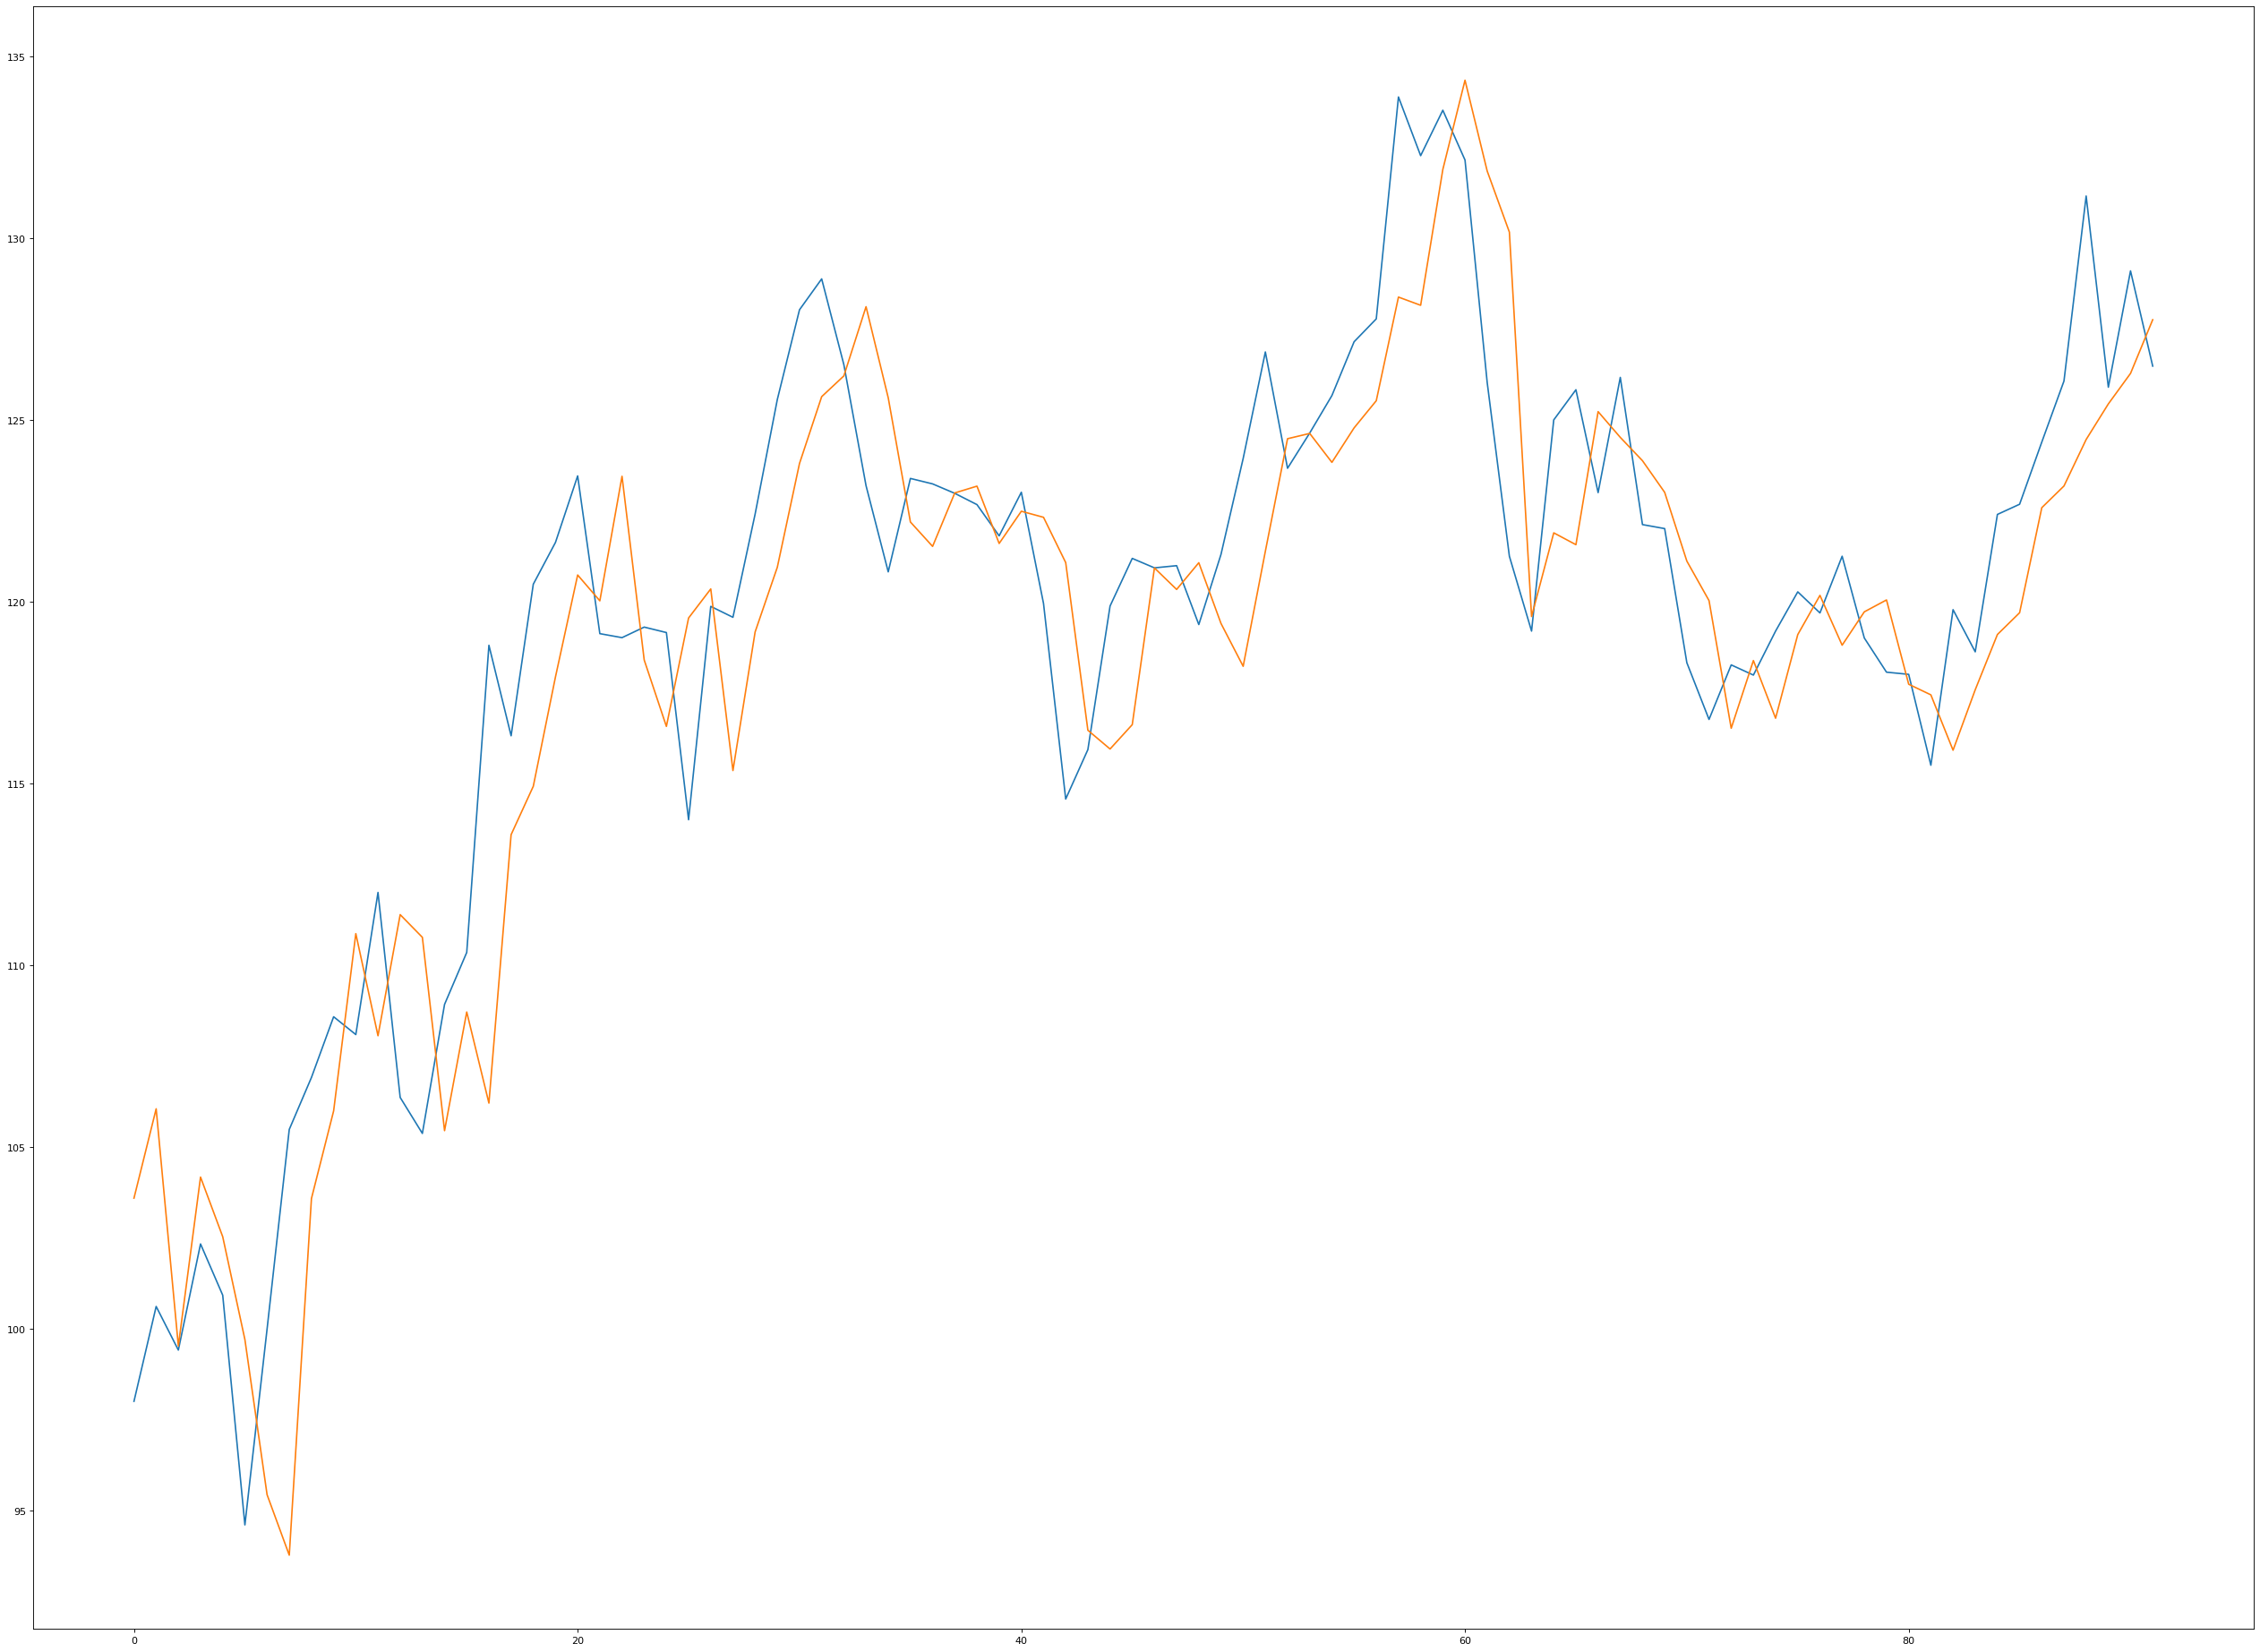

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 8 days + prediction of last 4 days

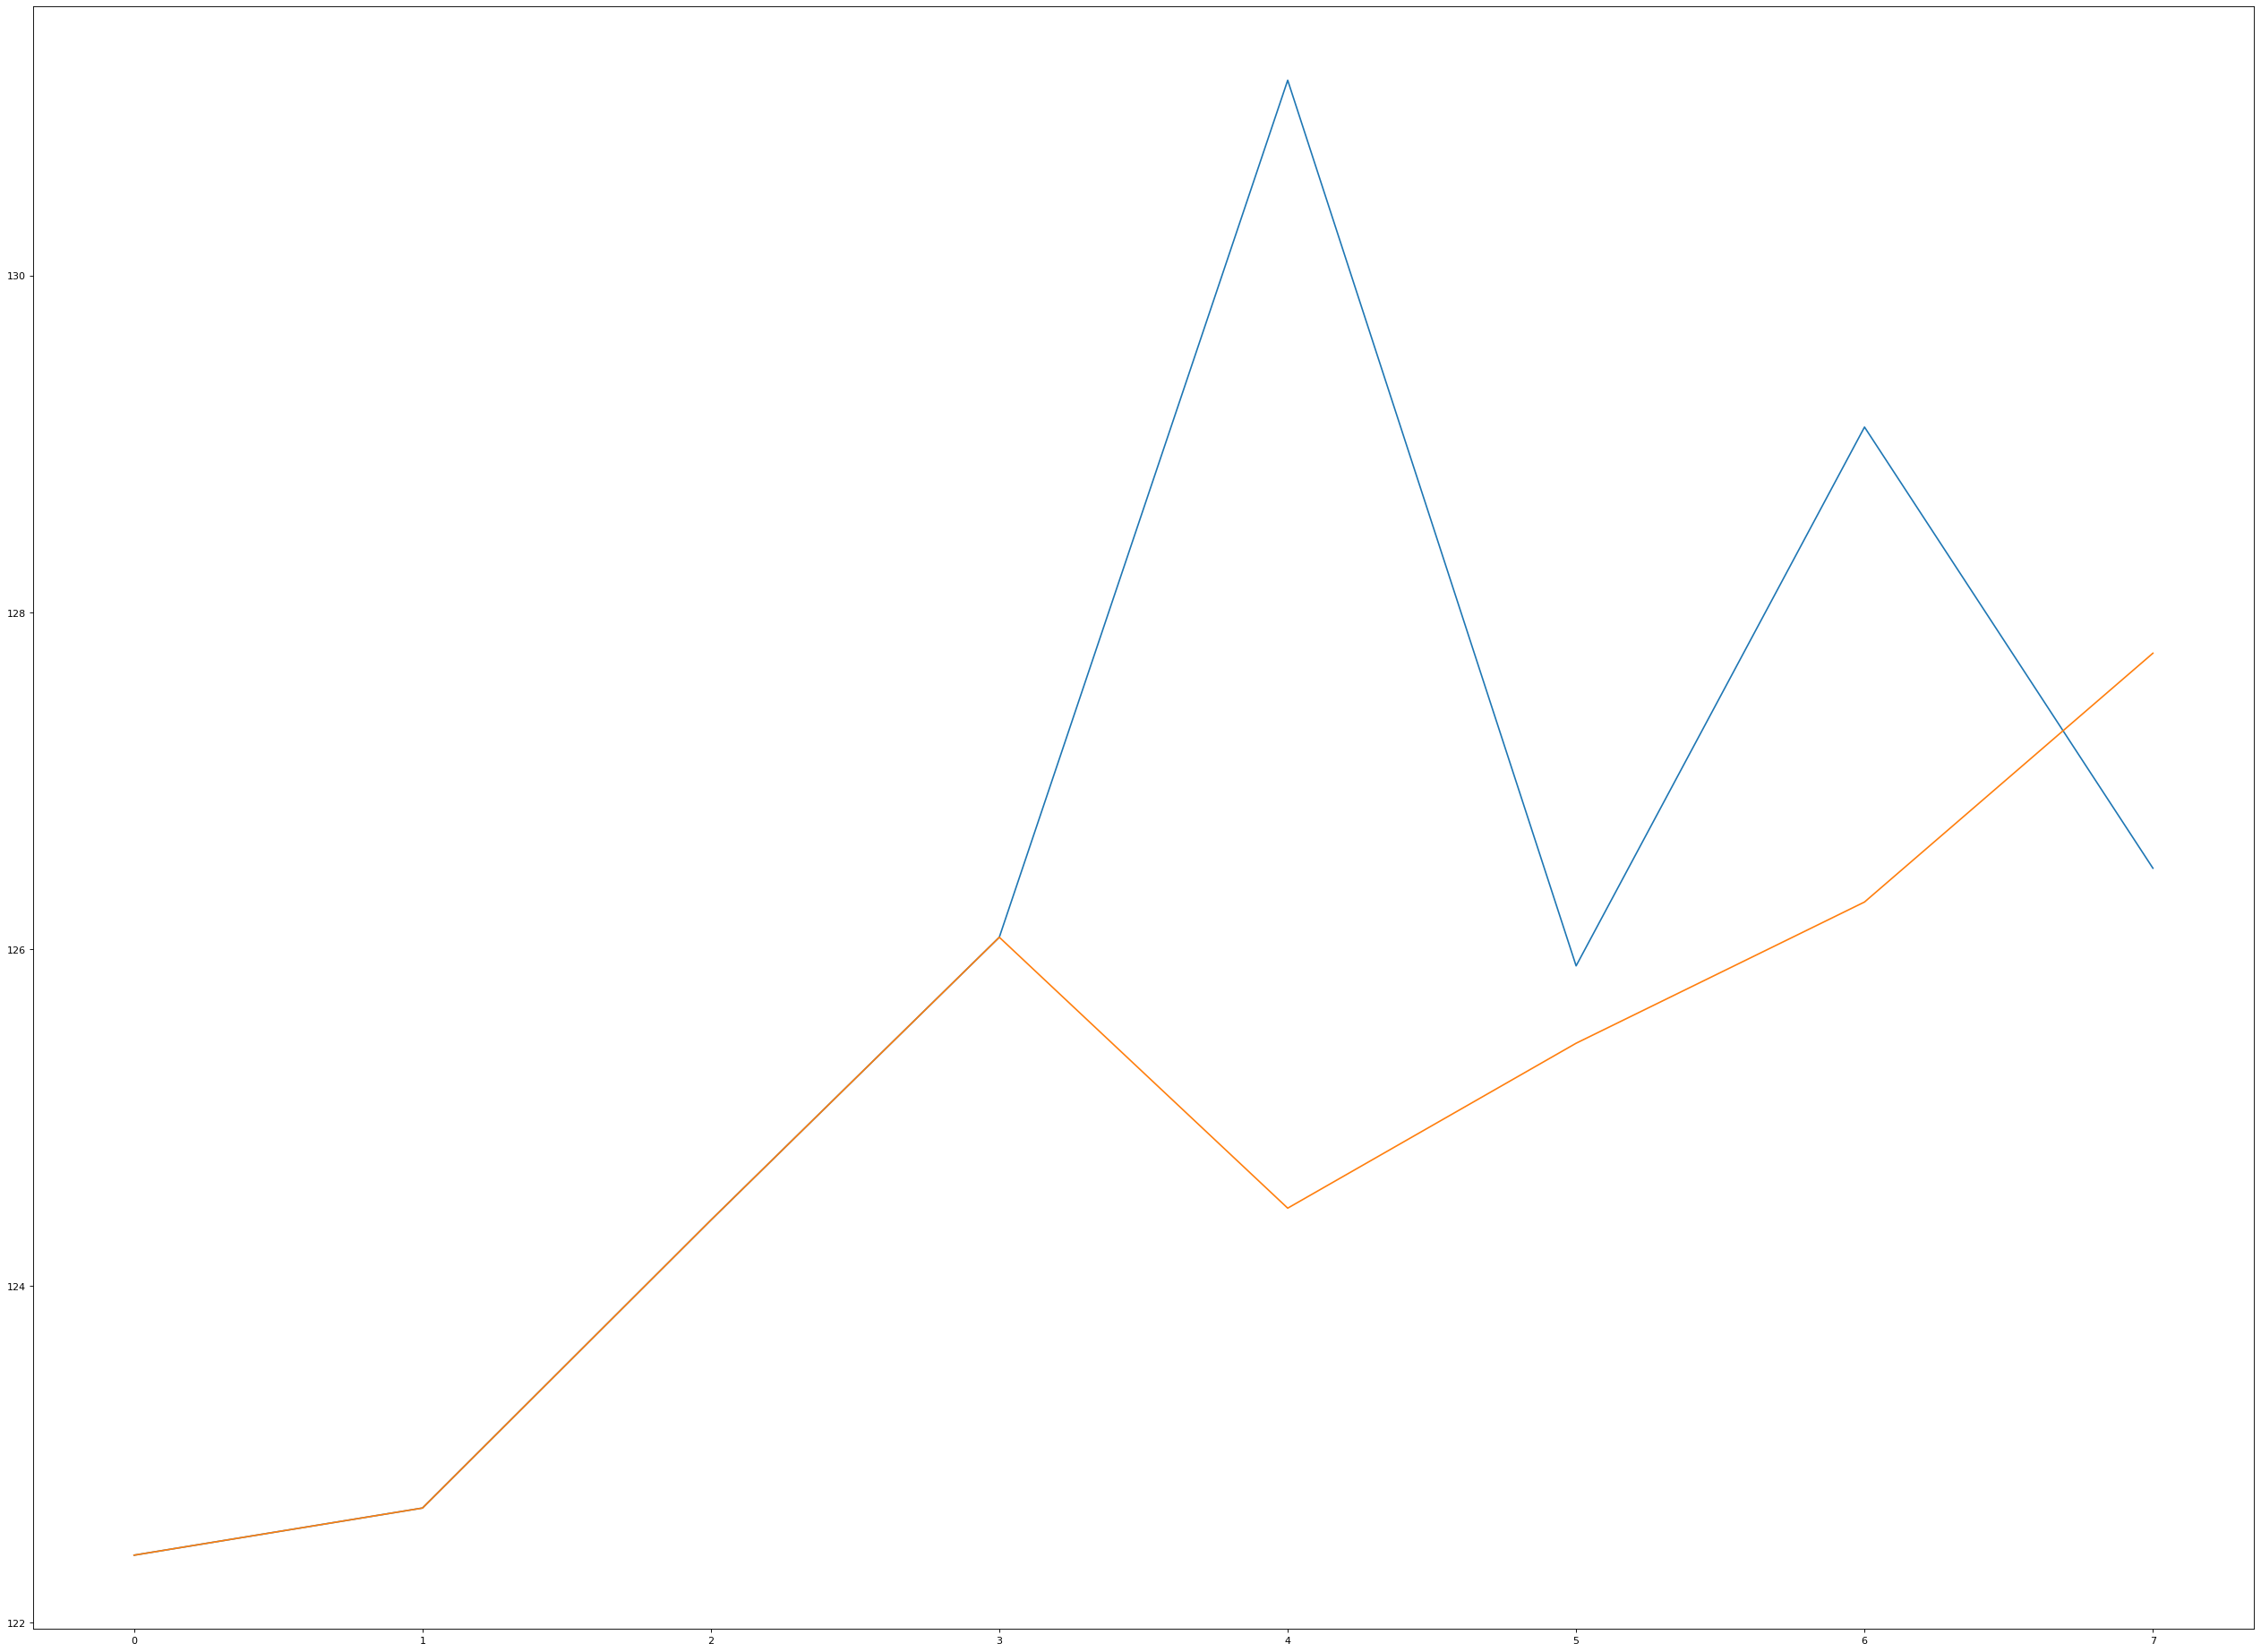

In [36]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(8), true_y_test[-8:])
plt.plot(range(8), np.append(true_y_test[-8:-4], predicted_y_test[-4:]))
plt.show()